# U-Net: Convolutional Networks for Image Segmentation

## Imports

In [29]:
import os
import cv2
import time
import random
import numpy as np
from glob import glob
from tqdm import tqdm
from operator import add
from collections import defaultdict
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize, dilation, diamond
import albumentations as A

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score


## Dataset class

In [30]:
class STAREDataset(Dataset):
    def __init__(self, images_path, masks_path, augmentation=False, nb_aug=2):
        """
        Args:
            images_path (list): List of paths to the images.
            masks_path (list): List of paths to the masks.
            augmentation (bool): Enables or disables data augmentation.
            nb_aug (int): Number of augmentations to generate per image.
        """

        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)
        self.augmentation = augmentation
        self.nb_aug = nb_aug
        
        if self.augmentation:
            # Augmentation dataset pipeline
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomRotate90(p=1.0),
                A.ShiftScaleRotate(shift_limit=0, scale_limit=0.33, rotate_limit=0, border_mode=cv2.BORDER_REFLECT_101, p=0.7)
            ], additional_targets={'mask': 'mask', 'weight': 'mask'})

    def __len__(self):
        if self.augmentation:
            return self.n_samples * (1 + self.nb_aug)
        else:
            return self.n_samples

    def __getitem__(self, index):

        if self.augmentation:
            image_idx = index // (1 + self.nb_aug)
            variant = index % (1 + self.nb_aug)
        else:
            image_idx = index
            variant = 0

        image = cv2.imread(self.images_path[image_idx], cv2.IMREAD_COLOR)  # (H, W, 3)
        image = image / 255.0  # pixel in [0,1]

        mask = cv2.imread(self.masks_path[image_idx], cv2.IMREAD_GRAYSCALE)  # (H, W)
        mask = mask / 255.0

        mask_tensor = torch.from_numpy(mask[np.newaxis, ...]).float()  # (1, H, W)
        weight_tensor = self._compute_weight_map(mask_tensor)           # (1, H, W)
        weight = weight_tensor.squeeze(0).numpy()  # (H, W)

        if not self.augmentation or variant == 0:
            # Convert to format (3, H, W)
            image_t = torch.from_numpy(np.transpose(image, (2, 0, 1)).astype(np.float32))
            mask_t = torch.from_numpy(mask[np.newaxis, ...].astype(np.float32))
            return image_t, mask_t, weight_tensor

        augmented = self.transform(image=image, mask=mask, weight=weight)
        aug_img = augmented['image']       # (H, W, 3)
        aug_mask = augmented['mask']       # (H, W)
        aug_weight = augmented['weight']   # (H, W)

        aug_img_t = torch.from_numpy(np.transpose(aug_img, (2, 0, 1)).astype(np.float32))
        aug_mask_t = torch.from_numpy(aug_mask[np.newaxis, ...].astype(np.float32))
        aug_weight_t = torch.from_numpy(aug_weight[np.newaxis, ...].astype(np.float32))
        return aug_img_t, aug_mask_t, aug_weight_t

    def _compute_weight_map(self, mask_t, w0=10, sigma=7, background_class=0):
        """
        Computes a weight map for a binary mask to emphasize boundary regions.

        Args:
            mask_t (torch.Tensor): Binary mask tensor of shape (1, H, W) with float32 values in [0,1].
            w0 (int, optional): Maximum weight applied to boundary regions. Default is 10.
            sigma (int, optional): Controls the spread of weight influence around boundaries. Default is 7.
            background_class (int, optional): Label of the background class in the mask. Default is 0.

        Returns:
            torch.Tensor: Weight map tensor of shape (1, H, W), where higher values highlight critical areas.
        """
    
        mask_np = mask_t.squeeze(0).cpu().numpy()  # (H, W)
        mask_bin = (mask_np > 0.5).astype(np.uint8)  # Binary mask (0 or 1)

        wc = self._class_weights(mask_bin)

        _, regions = cv2.connectedComponents(mask_bin)
        region_ids = sorted(np.unique(regions))
        region_ids = [r for r in region_ids if r != background_class]

        if len(region_ids) > 1:
            distances = np.zeros((mask_bin.shape[0], mask_bin.shape[1], len(region_ids)), dtype=np.float32)
            for i, region_id in enumerate(region_ids):
                m = (regions != region_id).astype(np.uint8)
                distances[:, :, i] = cv2.distanceTransform(m, distanceType=cv2.DIST_L2, maskSize=0)
            distances = np.sort(distances, axis=2)
            d1, d2 = distances[:, :, 0], distances[:, :, 1]
            w_map = w0 * np.exp(-1.0 / (2.0 * sigma**2) * (d1 + d2)**2) * (regions == background_class)
        else:
            w_map = np.zeros_like(mask_bin, dtype=np.float32)

        wc_x = np.zeros_like(mask_bin, dtype=np.float32)
        for pixel_class, weight_val in wc.items():
            wc_x[mask_bin == pixel_class] = weight_val
        w_map = w_map + wc_x
        
        w_t = torch.from_numpy(w_map).unsqueeze(0).float() # (1, H, W)
        return w_t

    def _class_weights(self, mask_bin):
        """
        Computes a dictionary of class weights based on pixel frequency in the binary mask.

        Args:
            mask_bin (numpy.ndarray): Binary mask (H, W) with values 0 or 1.

        Returns:
            dict: A dictionary where keys are class labels (0 or 1) and values are the corresponding weights.
                The weighting balances class frequencies by assigning higher weights to less frequent classes.
        """
        wc = defaultdict(float)
        unique, counts = np.unique(mask_bin, return_counts=True)
        total_px = mask_bin.size  

        freqs = counts / float(total_px)
        max_count = max(freqs)

        for val, fr in zip(unique, freqs):
            wc[val] = max_count / fr 
        return wc


## Weight map visualisation

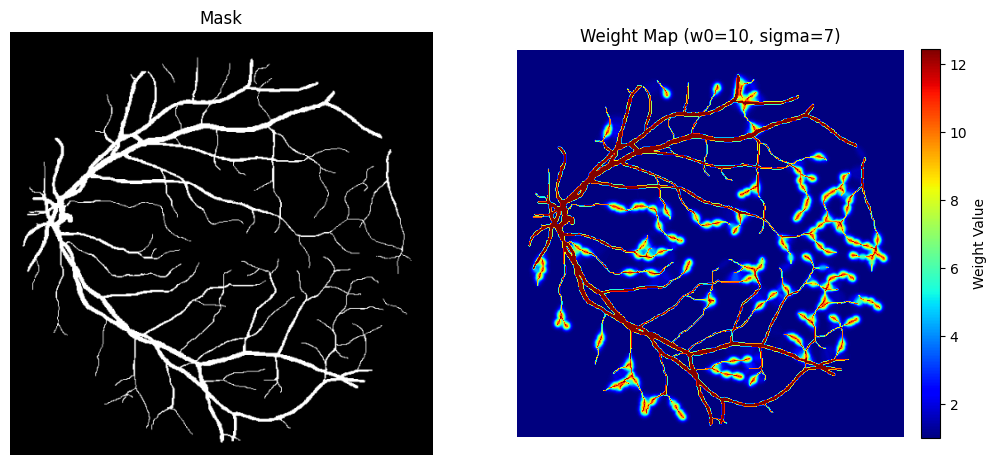

In [31]:
images_path = sorted(glob('data/retine/train/image/*.png'))
masks_path = sorted(glob('data/retine/train/mask/*.png'))

W0 = 10
SIGMA = 7

dataset = STAREDataset(images_path=images_path, masks_path=masks_path)
_, mask, _ = dataset[0]  

weight_t = dataset._compute_weight_map(mask, w0=W0, sigma=SIGMA)

mask_np = mask.squeeze().cpu().numpy()
weight_np = weight_t.squeeze().cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(mask_np, cmap='gray')
axes[0].set_title("Mask")
axes[0].axis("off")

im = axes[1].imshow(weight_np, cmap='jet')
axes[1].set_title("Weight Map (w0={}, sigma={})".format(W0, SIGMA))
axes[1].axis("off")

cbar = plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
cbar.set_label('Weight Value')

plt.show()

## Dataset augmentation visualisation

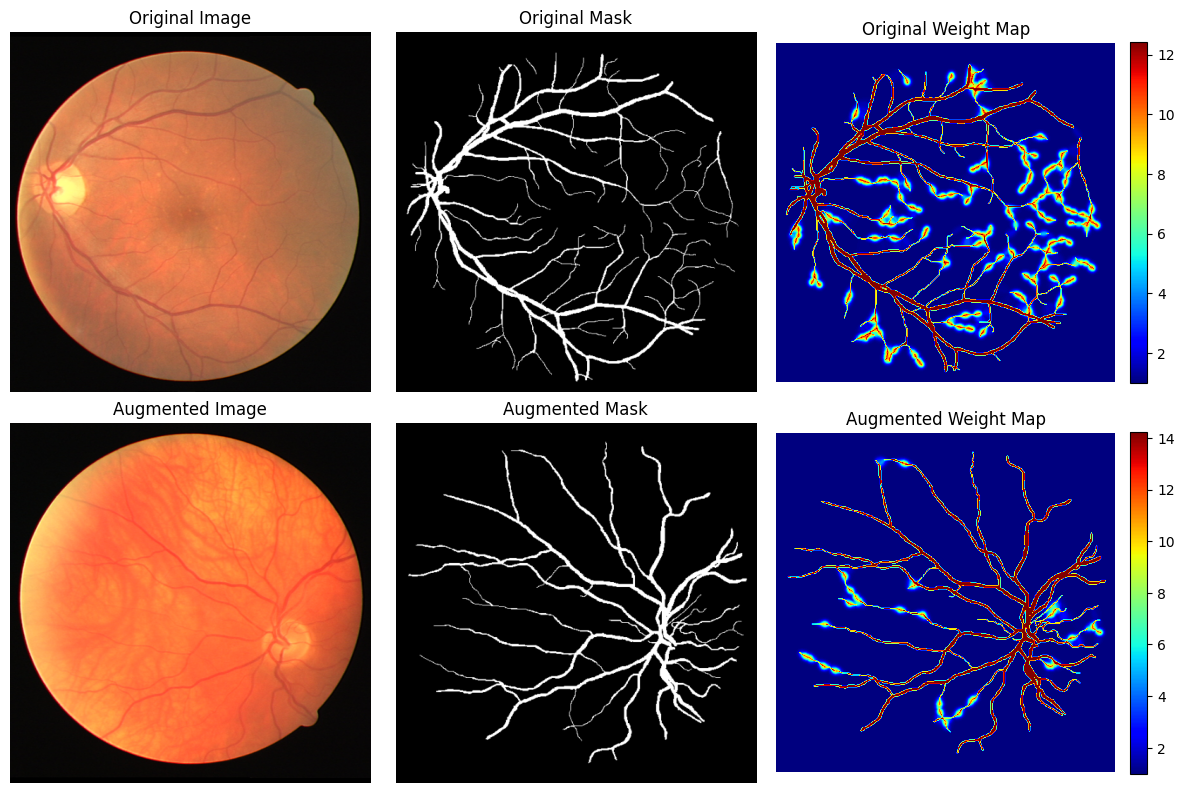

In [32]:
orig_img_t, orig_mask_t, orig_weight_t = dataset[0]
aug_img_t, aug_mask_t, aug_weight_t = dataset[2]

# Managing channels for visualisation with matplotlib
orig_img = orig_img_t.numpy().transpose(1, 2, 0)  
aug_img = aug_img_t.numpy().transpose(1, 2, 0)

orig_mask = orig_mask_t.numpy().squeeze(0)      
aug_mask = aug_mask_t.numpy().squeeze(0)

orig_weight = orig_weight_t.numpy().squeeze(0)
aug_weight = aug_weight_t.numpy().squeeze(0)

orig_img = cv2.cvtColor((orig_img * 255).astype(np.uint8), cv2.COLOR_BGR2RGB)
aug_img = cv2.cvtColor((aug_img * 255).astype(np.uint8), cv2.COLOR_BGR2RGB)


fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs[0, 0].imshow(orig_img)
axs[0, 0].set_title("Original Image")
axs[0, 1].imshow(orig_mask, cmap='gray')
axs[0, 1].set_title("Original Mask")

im0 = axs[0, 2].imshow(orig_weight, cmap='jet')
axs[0, 2].set_title("Original Weight Map")
cbar0 = plt.colorbar(im0, ax=axs[0, 2], fraction=0.046, pad=0.04)  

axs[1, 0].imshow(aug_img)
axs[1, 0].set_title("Augmented Image")
axs[1, 1].imshow(aug_mask, cmap='gray')
axs[1, 1].set_title("Augmented Mask")

im1 = axs[1, 2].imshow(aug_weight, cmap='jet')
axs[1, 2].set_title("Augmented Weight Map")
cbar1 = plt.colorbar(im1, ax=axs[1, 2], fraction=0.046, pad=0.04)  

for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()


## UNET architecture classes

In [33]:
class ConvBlock(nn.Module):
    """
    Convolutional block that consists of:
      - Two 3x3 convolution layers with padding=1
      - Two batch normalization layers
      - ReLU activation after each convolution

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
    """
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the convolutional block.
        """
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

class EncoderBlock(nn.Module):
    """
    Encoder block consisting of:
      - A convolutional block (ConvBlock)
      - A max pooling operation to reduce spatial dimensions

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
    """
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x: torch.Tensor) -> (torch.Tensor, torch.Tensor):
        """
        Forward pass of the encoder block.

        Returns:
          - The skip connection output before pooling
          - The pooled output for the next U-Net layer
        """
        skip = self.conv(x)
        pooled = self.pool(skip)
        return skip, pooled

class DecoderBlock(nn.Module):
    """
    Decoder block consisting of:
      - A transposed convolution (ConvTranspose2d) to upsample
      - A convolutional block (ConvBlock) after concatenation with the skip connection

    Args:
        in_channels (int): Number of input channels to the transposed convolution.
        out_channels (int): Number of output channels.
    """
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = ConvBlock(out_channels * 2, out_channels)

    def forward(self, x: torch.Tensor, skip: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the decoder block.

        Args:
            x (torch.Tensor): Main input (from the previous decoder step).
            skip (torch.Tensor): Skip connection from the corresponding encoder step.

        Returns:
            torch.Tensor: Output of the decoder block.
        """
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)  
        x = self.conv(x)
        return x


class UNet(nn.Module):
    """
    U-Net architecture implementation:
      - 4 encoder blocks
      - 1 bottleneck block
      - 4 decoder blocks
      - 1 final output layer with 1 channel for binary segmentation
    """
    def __init__(self):
        super().__init__()

        # Encoder
        self.encoder1 = EncoderBlock(in_channels=3, out_channels=64)
        self.encoder2 = EncoderBlock(in_channels=64, out_channels=128)
        self.encoder3 = EncoderBlock(in_channels=128, out_channels=256)
        self.encoder4 = EncoderBlock(in_channels=256, out_channels=512)

        # Bottleneck
        self.bottleneck = ConvBlock(in_channels=512, out_channels=1024)

        # Decoder
        self.decoder1 = DecoderBlock(in_channels=1024, out_channels=512)
        self.decoder2 = DecoderBlock(in_channels=512, out_channels=256)
        self.decoder3 = DecoderBlock(in_channels=256, out_channels=128)
        self.decoder4 = DecoderBlock(in_channels=128, out_channels=64)

        # Output layer (1x1 convolution to generate a single-channel segmentation map)
        self.output_conv = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the U-Net model.

        Args:
            x (torch.Tensor): Input image of shape (N, C, H, W).
        
        Returns:
            torch.Tensor: Segmentation output of shape (N, 1, H, W).
        """
        # Encoding
        s1, p1 = self.encoder1(x)
        s2, p2 = self.encoder2(p1)
        s3, p3 = self.encoder3(p2)
        s4, p4 = self.encoder4(p3)

        # Bottleneck
        b = self.bottleneck(p4)

        # Decoding
        d1 = self.decoder1(b, s4)
        d2 = self.decoder2(d1, s3)
        d3 = self.decoder3(d2, s2)
        d4 = self.decoder4(d3, s1)

        # Output layer
        out = self.output_conv(d4)
        return out

## Losses classes

#### BCE Weighted Loss

In [34]:
class WeightedBCELoss(nn.Module):
    def __init__(self):
        super(WeightedBCELoss, self).__init__()

    def forward(self, inputs, targets, weights=None):
        """
        Args:
            inputs (torch.Tensor): Network logits of shape (B, 1, H, W).
            targets (torch.Tensor): Binary masks of shape (B, 1, H, W).
            weights (torch.Tensor): Weight map of shape (B, 1, H, W).
        """
        
        bce_raw = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')

        if weights is None:
            return bce_raw.mean()
        
        bce_weighted = bce_raw * weights
        bce_weighted_loss = bce_weighted.mean()
    
        return bce_weighted_loss
    

#### Skeleton Recall Loss

In [35]:
class SkeletonRecallLoss(nn.Module):
    def __init__(self, smooth=0, lambda_loss=0.2):
        """
        Args:
            smooth (float): Small term for numerical stability.
            lambda_loss (float): Weight associated with the Skeleton Recall Loss.
        """
        super(SkeletonRecallLoss, self).__init__()
        self.smooth = smooth
        self.lambda_loss = lambda_loss

    def forward(self, inputs, targets, weights=None):
        """
        Args:
            inputs (torch.Tensor): Network logits (B, 1, H, W).
            targets (torch.Tensor): Ground-truth binary masks (B, 1, H, W).
            weights (torch.Tensor|None): Optional, whether or not to compute the Weighted BCE.
        """
     
        inputs_sig = torch.sigmoid(inputs)
        targets_skel = self._tubed_skeletonization(targets)
        pred_flat = inputs_sig.view(-1)
        skel_flat = targets_skel.view(-1)
        intersection = (pred_flat * skel_flat).sum()
        skeleton_recall = 1.0 - (intersection + self.smooth) / (skel_flat.sum() + self.smooth)
        
        bce_weighted = WeightedBCELoss()
        loss_bce_weighted = bce_weighted(inputs, targets, weights) 
        loss_total = loss_bce_weighted + self.lambda_loss * skeleton_recall

        return loss_total
    
    def _tubed_skeletonization(self, mask):
        """
        Extracts a tubular skeleton from binary masks.
        Apply skeletonization, followed by dilation, and then mask with the ground truth
        to remove false positives outside the skeleton.
        """

        mask_np = mask.cpu().numpy()  
        skel = np.zeros_like(mask_np, dtype=np.uint8)

        for i in range(mask_np.shape[0]):
            skeleton = skeletonize(mask_np[i, 0])
            dilated_skeleton = dilation(skeleton, diamond(1))
            skel[i, 0] = np.logical_and(dilated_skeleton, mask_np[i, 0])

        return torch.tensor(skel, dtype=torch.float32, device=mask.device)


### Skeleton visualisation 

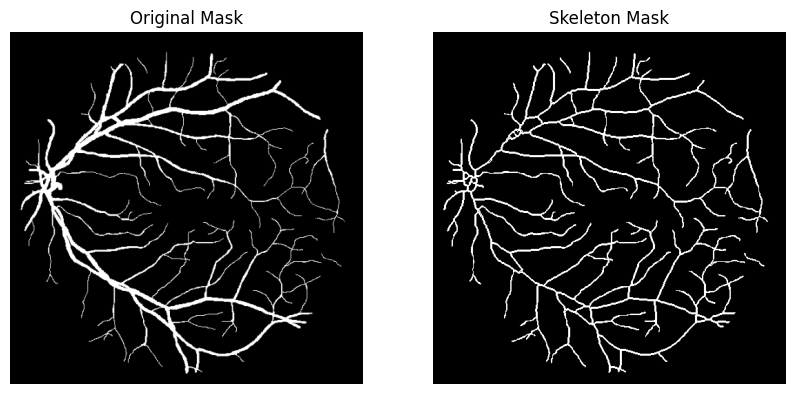

In [36]:
index = 0
_, mask, _ = dataset[index]  
loss = SkeletonRecallLoss()
skeleton = loss._tubed_skeletonization(mask.unsqueeze(0)).squeeze(0).cpu().numpy()
skeleton = skeleton.squeeze(0)
mask_np = mask.squeeze(0).cpu().numpy()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(mask_np, cmap='gray')
ax[0].set_title("Original Mask")
ax[0].axis("off")

ax[1].imshow(skeleton, cmap='gray')
ax[1].set_title("Skeleton Mask")
ax[1].axis("off")

plt.show()

# Data Preprocessing

In [37]:
model_path = './model'

if not os.path.exists(model_path):
        os.makedirs(model_path)

batch_size = 2
lr = 1e-4

train_image = sorted(glob("data/retine/train/image/*.png"))
train_mask = sorted(glob("data/retine/train/mask/*.png"))

test_image = sorted(glob("data/retine/test/image/*.png"))
test_mask = sorted(glob("data/retine/test/mask/*.png"))

train_dataset = STAREDataset(train_image, train_mask, augmentation=True, nb_aug=2)
test_dataset = STAREDataset(test_image, test_mask, augmentation=True, nb_aug=1)

print(f"len train dataset: {len(train_dataset)}")
print(f"len valid dataset: {len(test_dataset)}")


train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

len train dataset: 240
len valid dataset: 40


/home/marius/envs/main_venv/lib/python3.12/site-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


# Unet Model

In [38]:
best_path = "model/best.pth" # path to save the best model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet()
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)

loss = SkeletonRecallLoss()

# Model Training

In [39]:
def train(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0
    model.train()

    loop = tqdm(loader, desc="Loader samples", leave=False, total=len(loader))

    for batch_idx, (x, y, w) in enumerate(loop):
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)
        w = w.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y, w)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

        loop.update(1)  
        loop.set_postfix(loss=(epoch_loss / (batch_idx + 1)))
    epoch_loss /= len(loader)
    return epoch_loss

def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x, y, w in loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)
            w = w.to(device, dtype=torch.float32)

            y_pred = model(x)
            loss = loss_fn(y_pred, y, w)
            epoch_loss += loss.item()

        epoch_loss = epoch_loss / len(loader)
    return epoch_loss

In [40]:
best_valid_loss = float("inf")
num_epochs = 25
train_losses = []
valid_losses = []

epoch_loop = tqdm(range(num_epochs), desc="Training Progress", dynamic_ncols=True, unit="epoch")

for epoch in epoch_loop:
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, loss, device)
    valid_loss = evaluate(model, test_loader, loss, device)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    epoch_loop.set_postfix(train_loss=train_loss, test_loss=valid_loss)

    if valid_loss < best_valid_loss:
        print(f"Valid loss improved from {best_valid_loss:.4f} to {valid_loss:.4f}. Saving best model: {best_path}")
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), best_path)

    print(f"Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}\n")

epoch_loop.close() 

Training Progress:   0%|          | 0/25 [00:00<?, ?epoch/s]

Loader samples:   0%|          | 0/120 [00:00<?, ?it/s]

Valid loss improved from inf to 0.9066. Saving best model: model/best.pth
Epoch: 01 | Train Loss: 1.052 | Val. Loss: 0.907



Loader samples:   0%|          | 0/120 [00:00<?, ?it/s]

Valid loss improved from 0.9066 to 0.7840. Saving best model: model/best.pth
Epoch: 02 | Train Loss: 0.843 | Val. Loss: 0.784



Loader samples:   0%|          | 0/120 [00:00<?, ?it/s]

Valid loss improved from 0.7840 to 0.7212. Saving best model: model/best.pth
Epoch: 03 | Train Loss: 0.767 | Val. Loss: 0.721



Loader samples:   0%|          | 0/120 [00:00<?, ?it/s]

Valid loss improved from 0.7212 to 0.6712. Saving best model: model/best.pth
Epoch: 04 | Train Loss: 0.712 | Val. Loss: 0.671



Loader samples:   0%|          | 0/120 [00:00<?, ?it/s]

Valid loss improved from 0.6712 to 0.6577. Saving best model: model/best.pth
Epoch: 05 | Train Loss: 0.679 | Val. Loss: 0.658



Loader samples:   0%|          | 0/120 [00:00<?, ?it/s]

Valid loss improved from 0.6577 to 0.6362. Saving best model: model/best.pth
Epoch: 06 | Train Loss: 0.652 | Val. Loss: 0.636



Loader samples:   0%|          | 0/120 [00:00<?, ?it/s]

Valid loss improved from 0.6362 to 0.6161. Saving best model: model/best.pth
Epoch: 07 | Train Loss: 0.632 | Val. Loss: 0.616



Loader samples:   0%|          | 0/120 [00:00<?, ?it/s]

Valid loss improved from 0.6161 to 0.5984. Saving best model: model/best.pth
Epoch: 08 | Train Loss: 0.616 | Val. Loss: 0.598



Loader samples:   0%|          | 0/120 [00:00<?, ?it/s]

Valid loss improved from 0.5984 to 0.5972. Saving best model: model/best.pth
Epoch: 09 | Train Loss: 0.603 | Val. Loss: 0.597



Loader samples:   0%|          | 0/120 [00:00<?, ?it/s]

Valid loss improved from 0.5972 to 0.5889. Saving best model: model/best.pth
Epoch: 10 | Train Loss: 0.596 | Val. Loss: 0.589



Loader samples:   0%|          | 0/120 [00:00<?, ?it/s]

Valid loss improved from 0.5889 to 0.5842. Saving best model: model/best.pth
Epoch: 11 | Train Loss: 0.591 | Val. Loss: 0.584



Loader samples:   0%|          | 0/120 [00:00<?, ?it/s]

Valid loss improved from 0.5842 to 0.5758. Saving best model: model/best.pth
Epoch: 12 | Train Loss: 0.578 | Val. Loss: 0.576



Loader samples:   0%|          | 0/120 [00:00<?, ?it/s]

Valid loss improved from 0.5758 to 0.5712. Saving best model: model/best.pth
Epoch: 13 | Train Loss: 0.572 | Val. Loss: 0.571



Loader samples:   0%|          | 0/120 [00:00<?, ?it/s]

Valid loss improved from 0.5712 to 0.5699. Saving best model: model/best.pth
Epoch: 14 | Train Loss: 0.566 | Val. Loss: 0.570



Loader samples:   0%|          | 0/120 [00:00<?, ?it/s]

Valid loss improved from 0.5699 to 0.5635. Saving best model: model/best.pth
Epoch: 15 | Train Loss: 0.563 | Val. Loss: 0.563



Loader samples:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch: 16 | Train Loss: 0.567 | Val. Loss: 0.576



Loader samples:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch: 17 | Train Loss: 0.565 | Val. Loss: 0.567



Loader samples:   0%|          | 0/120 [00:00<?, ?it/s]

Valid loss improved from 0.5635 to 0.5624. Saving best model: model/best.pth
Epoch: 18 | Train Loss: 0.556 | Val. Loss: 0.562



Loader samples:   0%|          | 0/120 [00:00<?, ?it/s]

Valid loss improved from 0.5624 to 0.5616. Saving best model: model/best.pth
Epoch: 19 | Train Loss: 0.549 | Val. Loss: 0.562



Loader samples:   0%|          | 0/120 [00:00<?, ?it/s]

Valid loss improved from 0.5616 to 0.5582. Saving best model: model/best.pth
Epoch: 20 | Train Loss: 0.546 | Val. Loss: 0.558



Loader samples:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch: 21 | Train Loss: 0.540 | Val. Loss: 0.559



Loader samples:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch: 22 | Train Loss: 0.537 | Val. Loss: 0.562



Loader samples:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch: 23 | Train Loss: 0.537 | Val. Loss: 0.561



Loader samples:   0%|          | 0/120 [00:00<?, ?it/s]

Valid loss improved from 0.5582 to 0.5567. Saving best model: model/best.pth
Epoch: 24 | Train Loss: 0.533 | Val. Loss: 0.557



Loader samples:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch: 25 | Train Loss: 0.531 | Val. Loss: 0.557



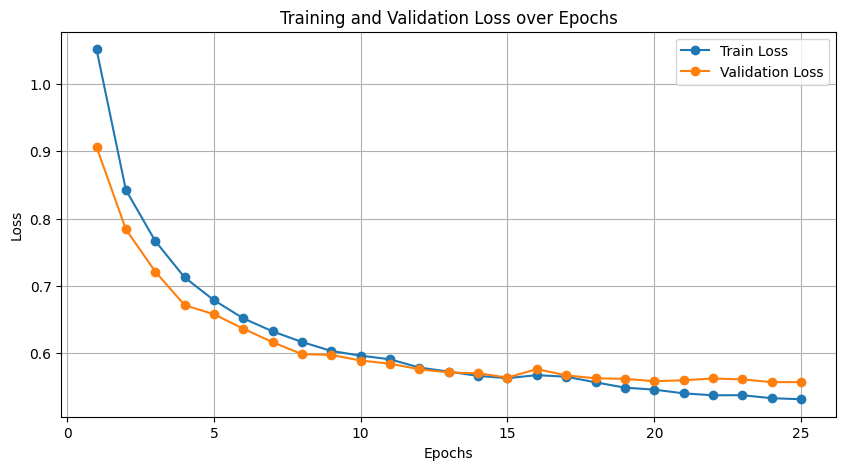

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid()
plt.show()


# Testing

### Load checkpoints file

In [42]:
best_path = "./model/best.pth"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet()
model = model.to(device)
model.load_state_dict(torch.load(best_path, map_location=device))
model.eval()

/tmp/ipykernel_27479/1930088257.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=device))


UNet(
  (encoder1): EncoderBlock(
    (conv): ConvBlock(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder2): EncoderBlock(
    (conv): ConvBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (pool): MaxPool2d(k

### Experiment results

### Utils

In [43]:
def mask_parse(mask):

    mask = np.expand_dims(mask, axis=-1)

    return np.concatenate([mask] * 3, axis=-1)

def preprocess_image(image_path, device):

    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = np.transpose(image, (2, 0, 1)) / 255.0

    return torch.tensor(image, dtype=torch.float32).unsqueeze(0).to(device)

def preprocess_mask(mask_path, device):

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask / 255.0, axis=(0, 1))

    return torch.tensor(mask, dtype=torch.float32).to(device)

def predict(model, image_tensor):

    with torch.no_grad():
        start_time = time.time()
        pred = torch.sigmoid(model(image_tensor))
        inference_time = time.time() - start_time

    return pred, inference_time

def postprocess_prediction(pred):
    
    if isinstance(pred, torch.Tensor):
        pred = pred.cpu().numpy()  

    return (pred > 0.5).astype(np.uint8) 


def save_result(image, mask, pred_mask, output_path):
    pred_mask = pred_mask.squeeze() 
    result = np.concatenate([image, mask_parse(mask), mask_parse(pred_mask * 255)], axis=1)
    cv2.imwrite(output_path, result)


def calculate_metrics(y_true, y_pred):

    y_true = (y_true.cpu().numpy() > 0.5).astype(np.uint8).reshape(-1)
    y_pred = (y_pred.cpu().numpy() > 0.5).astype(np.uint8).reshape(-1)

    return [
        jaccard_score(y_true, y_pred),      
        f1_score(y_true, y_pred),            
        recall_score(y_true, y_pred),        
        precision_score(y_true, y_pred),     
        accuracy_score(y_true, y_pred)         
    ]

def print_metrics(all_metrics, time_taken):

    all_metrics = np.array(all_metrics)  
    mean_metrics = np.mean(all_metrics, axis=0) 

    jaccard, f1, recall, precision, acc = mean_metrics
    avg_inference_time = np.mean(time_taken)

    print(f"Jaccard: {jaccard:.4f} - F1: {f1:.4f} - Recall: {recall:.4f} - Precision: {precision:.4f} - Acc: {acc:.4f}")
    print(f"Average inference time: {avg_inference_time:.4f} s")

def display_prediction(image_path):

    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir BGR en RGB pour affichage correct

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.show()



### Pipeline to display results

  0%|          | 0/20 [00:00<?, ?it/s]

Jaccard: 0.6448 - F1: 0.7837 - Recall: 0.9079 - Precision: 0.6926 - Acc: 0.9564
Average inference time: 0.0024 s


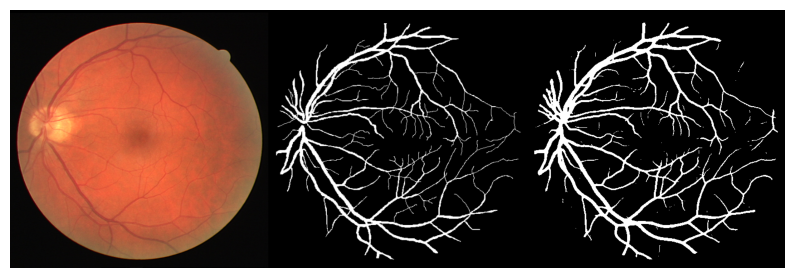

In [44]:
results_path = './results'
if not os.path.exists(results_path):
        os.makedirs(results_path)

all_metrics = [] 
time_taken = []


for x_path, y_path in tqdm(zip(test_image, test_mask), total=len(test_image)):
    name = os.path.splitext(os.path.basename(x_path))[0]

    image = cv2.imread(x_path, cv2.IMREAD_COLOR)
    image_tensor = preprocess_image(x_path, device)
    mask_tensor = preprocess_mask(y_path, device)
    
    pred, inference_time = predict(model, image_tensor)
    time_taken.append(inference_time)

    metrics_per_image = calculate_metrics(mask_tensor, pred)
    all_metrics.append(metrics_per_image)

    pred_mask = postprocess_prediction(pred)
    save_result(image, cv2.imread(y_path, cv2.IMREAD_GRAYSCALE), pred_mask, os.path.join(results_path, f"{name}.png"))

print_metrics(all_metrics, time_taken)
display_prediction('./results/11.png')
